In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as st

In [2]:
df = pd.read_csv("/datasets/games.csv") # Paso 1. Ruta del archivo

In [3]:
#Paso 2. Prepara los datos.

# Mostrar las 15 primeras filas del dataset
print(df.head(15))

# Convertir los nombres de las columnas a minúsculas
df.columns = df.columns.str.lower()

# Mostrar información general del dataset
df.info()

                           Name Platform  Year_of_Release         Genre  \
0                    Wii Sports      Wii           2006.0        Sports   
1             Super Mario Bros.      NES           1985.0      Platform   
2                Mario Kart Wii      Wii           2008.0        Racing   
3             Wii Sports Resort      Wii           2009.0        Sports   
4      Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
5                        Tetris       GB           1989.0        Puzzle   
6         New Super Mario Bros.       DS           2006.0      Platform   
7                      Wii Play      Wii           2006.0          Misc   
8     New Super Mario Bros. Wii      Wii           2009.0      Platform   
9                     Duck Hunt      NES           1984.0       Shooter   
10                   Nintendogs       DS           2005.0    Simulation   
11                Mario Kart DS       DS           2005.0        Racing   
12  Pokemon Gold/Pokemon 

Para convertir los datos a los tipos necesarios, tenemos que analizar cada columna y determinar si su tipo de dato actual es adecuado o si es necesario cambiarlo. Aquí está el análisis:

Año de lanzamiento.
year_of_release (float64) → Convertir a Int64 (enteros)
Motivo: Un año es un valor entero, pero algunos valores son NaN. Debemos convertirlo a Int64 en lugar de int estándar, ya que Int64 admite valores nulos en pandas.

user_score (object) → Convertir a float64 (números decimales)
Es una puntuación dada por los usuarios, debería ser un número, pero está almacenado como texto (object).
Motivo: Convertir a float64 para que se pueda analizar.

🚨 Posible problema: Puede haber valores no numéricos como "TBD" (To Be Determined). Necesitaremos manejarlos antes de la conversión.

Manejo de valores especiales y ausentes:

Valores NaN en year_of_release → Dejar como NaN y convertir a Int64 para manejar valores nulos.

Valores TBD en user_score → Convertirlos a NaN antes de cambiar el tipo de dato a float64.

In [4]:
# Convertir todos los valores 'tbd' a NaN (ignorando mayúsculas/minúsculas)
df['user_score'] = df['user_score'].str.lower().replace('tbd', np.nan)

# Convertir user_score a float64
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

# Convertir year_of_release a Int64 para manejar valores nulos
df['year_of_release'] = df['year_of_release'].astype('Int64')

# Verificar los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


🔹 Descripción de las columnas con cambios de tipo de datos:

user_score (de object a float64)

Motivo: Originalmente era de tipo object porque contenía valores numéricos junto con "TBD", que es texto. Se convirtió a float64 para poder realizar cálculos y análisis estadísticos. Los valores "TBD" fueron reemplazados por NaN, ya que representan datos no disponibles.

year_of_release (de float64 a Int64)

Motivo: Se almacenaba como float64, lo cual no es adecuado para años porque un año siempre es un número entero. Se convirtió a Int64, que permite manejar valores nulos sin problemas.


🔹 Tratamiento de valores ausentes:

Valores NaN en year_of_release:

Se dejaron como NaN porque no hay una forma fiable de imputarlos sin introducir sesgos. Un año incorrecto podría afectar el análisis de tendencias en el tiempo.

Valores NaN en user_score (antes TBD):

Se dejaron como NaN porque "TBD" significa "por determinar" y no representa una calificación válida. Sustituirlo por un número ficticio podría distorsionar los análisis de correlación entre puntuaciones y ventas.

🔹 Posibles razones para los valores ausentes:

Falta de datos en el momento del registro: Algunos juegos pueden haberse añadido a la base de datos sin ciertos detalles, especialmente si eran recientes en 2016.

Errores en la recolección de datos: Puede que no todos los juegos recibieran calificaciones de críticos o usuarios.
Juegos que no fueron evaluados: No todos los juegos son revisados por los usuarios o la crítica, lo que explicaría los valores ausentes en critic_score y user_score.

🔹 Manejo de la abreviatura "TBD" en user_score:

Se interpretó como datos pendientes de evaluación y se reemplazó por NaN, ya que no representaba una puntuación real.

In [5]:
# Completar valores NaN en 'user_score' y 'critic_score' con la mediana
df['user_score'].fillna(df['user_score'].median(), inplace=True)
df['critic_score'].fillna(df['critic_score'].median(), inplace=True)

# Calcular las ventas totales sumando las ventas en todas las regiones
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

# Verificar que la columna ha sido agregada correctamente
print(df[['name', 'total_sales']].head())

                       name  total_sales
0                Wii Sports        82.54
1         Super Mario Bros.        40.24
2            Mario Kart Wii        35.52
3         Wii Sports Resort        32.77
4  Pokemon Red/Pokemon Blue        31.38


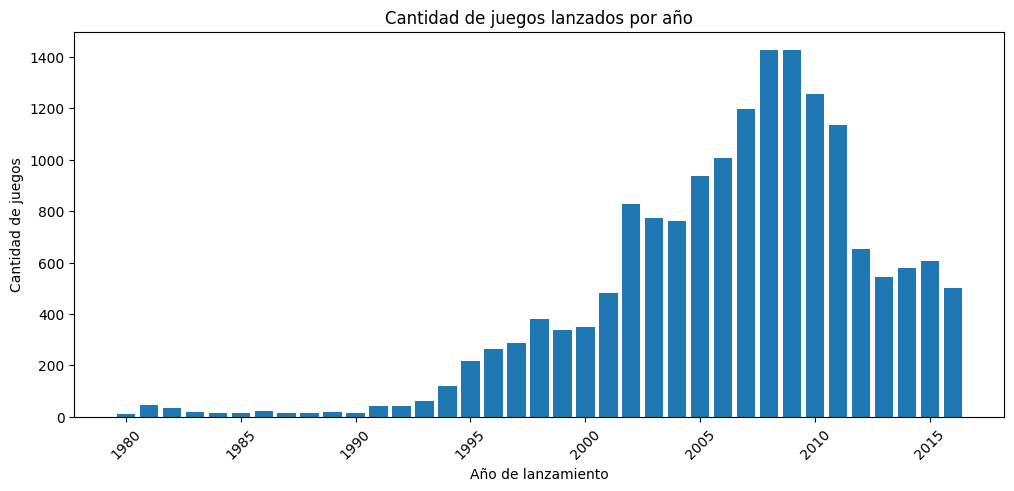

In [6]:
# Paso 3. Analiza los datos

# Contar cuántos juegos fueron lanzados en cada año
games_per_year = df['year_of_release'].value_counts().sort_index()

# Visualizar la cantidad de juegos lanzados por año
plt.figure(figsize=(12, 5))
plt.bar(games_per_year.index, games_per_year.values)
plt.xlabel('Año de lanzamiento')
plt.ylabel('Cantidad de juegos')
plt.title('Cantidad de juegos lanzados por año')
plt.xticks(rotation=45)
plt.show()

Análisis de la primera gráfica (Cantidad de juegos lanzados por año)

Se observa un aumento progresivo en la cantidad de juegos lanzados desde los años 1990 hasta su punto máximo alrededor de 2008-2009.

Después de 2009, hay una caída en el número de juegos lanzados, lo que podría indicar una consolidación del mercado, menos lanzamientos pero con mayor presupuesto o cambios en la industria como la transición a juegos digitales.

Los datos son significativos para el período de 1995 en adelante, ya que hay un número considerable de juegos. Antes de 1995, los datos pueden ser menos representativos debido a la menor cantidad de lanzamientos y registros disponibles.

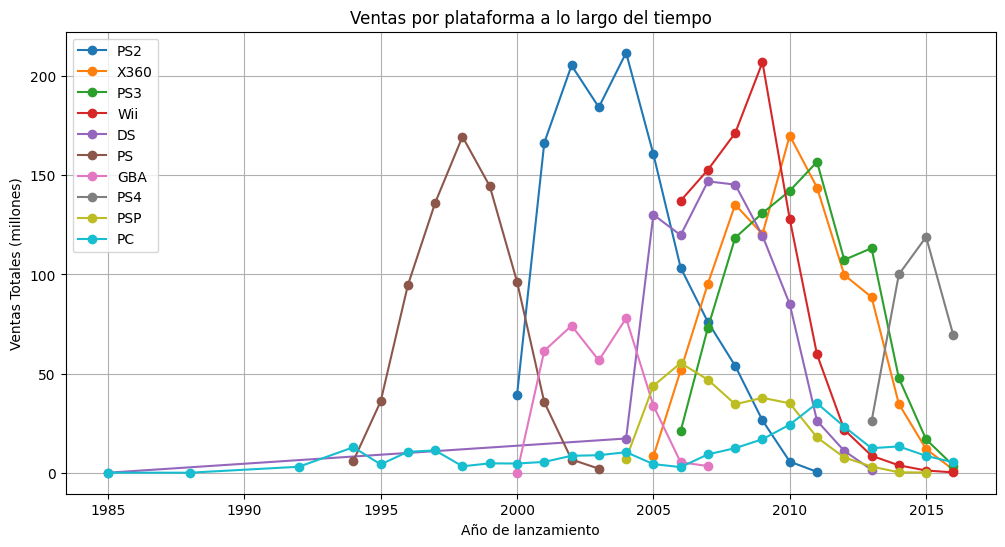

In [7]:
# Calcular las ventas totales por plataforma
platform_sales = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Seleccionar las plataformas con mayores ventas totales (Top 10)
top_platforms = platform_sales.head(10).index

# Filtrar datos para solo las plataformas principales
df_top_platforms = df[df['platform'].isin(top_platforms)]

# Construir distribución de ventas por año para las plataformas principales
plt.figure(figsize=(12, 6))
for platform in top_platforms:
    yearly_sales = df_top_platforms[df_top_platforms['platform'] == platform].groupby('year_of_release')['total_sales'].sum()
    plt.plot(yearly_sales.index, yearly_sales.values, marker='o', label=platform)

plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas Totales (millones)')
plt.title('Ventas por plataforma a lo largo del tiempo')
plt.legend()
plt.grid()

Análisis de la segunda gráfica (Ventas por plataforma a lo largo del tiempo)

🔹 Variación de ventas entre plataformas: Se observa que algunas plataformas dominan el mercado en ciertos períodos y luego desaparecen.

🔹 Plataformas que solían ser populares y ahora no tienen ventas:

PS2, Wii, DS, PSP, GBA tuvieron picos de ventas y posteriormente desaparecieron.

PS2 y Wii fueron extremadamente populares, pero sus ventas cayeron con la llegada de nuevas generaciones.

🔹 Tiempo de vida de una plataforma:

Generalmente, las plataformas duran entre 7 y 10 años antes de ser reemplazadas por nuevas tecnologías.

Ejemplo: PS2 tuvo su pico entre 2001-2008, y fue desplazada por PS3. Lo mismo ocurrió con Xbox 360, que fue reemplazada por Xbox One.

🔹 Nuevas plataformas: PS4 aparece con ventas en crecimiento, indicando que es una plataforma en auge en el período final de los datos.

En resumen, el mercado de los videojuegos es cíclico, con plataformas que dominan durante una década y luego desaparecen al ser reemplazadas por tecnologías más avanzadas.

Total de registros en el período relevante (>= 2010): 5277


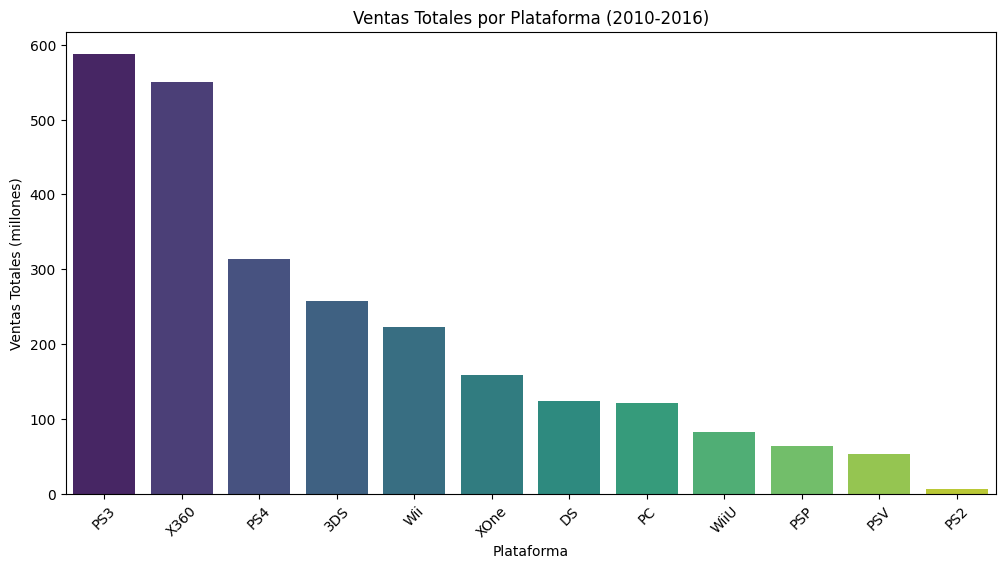

In [8]:
# Determinar el período relevante de datos (últimos años con suficiente información)
relevant_period = 2010  # Se elige desde 2010 en adelante basado en la tendencia observada.

# Filtrar el DataFrame para incluir solo los datos desde el período relevante
df_relevant = df[df['year_of_release'] >= relevant_period]

# Verificar el tamaño del nuevo conjunto de datos
print(f"Total de registros en el período relevante (>= {relevant_period}): {df_relevant.shape[0]}")

# Calcular las ventas totales por plataforma en el período relevante
platform_sales_recent = df_relevant.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Visualizar las plataformas líderes en ventas en el período relevante
plt.figure(figsize=(12, 6))
sns.barplot(x=platform_sales_recent.index, y=platform_sales_recent.values, palette="viridis")
plt.xlabel('Plataforma')
plt.ylabel('Ventas Totales (millones)')
plt.title(f'Ventas Totales por Plataforma ({relevant_period}-2016)')
plt.xticks(rotation=45)
plt.show()

💡 Filtrar el período relevante:

Basado en la gráfica de lanzamientos y ventas, se elige 2010 en adelante como el período clave para predecir el 2017.Hubo un pico de lanzamientos alrededor de 2008-2009, seguido de una caída. Después de 2010, los lanzamientos se estabilizan, lo que indica que los datos más recientes son más representativos de la industria moderna.

Se filtran los datos para incluir solo juegos lanzados en 2010 o después. 

💡 Identificar las plataformas líderes en ventas:

Se calculan las ventas totales por plataforma en el período filtrado.

Se genera un gráfico de barras con las plataformas con mayores ventas.

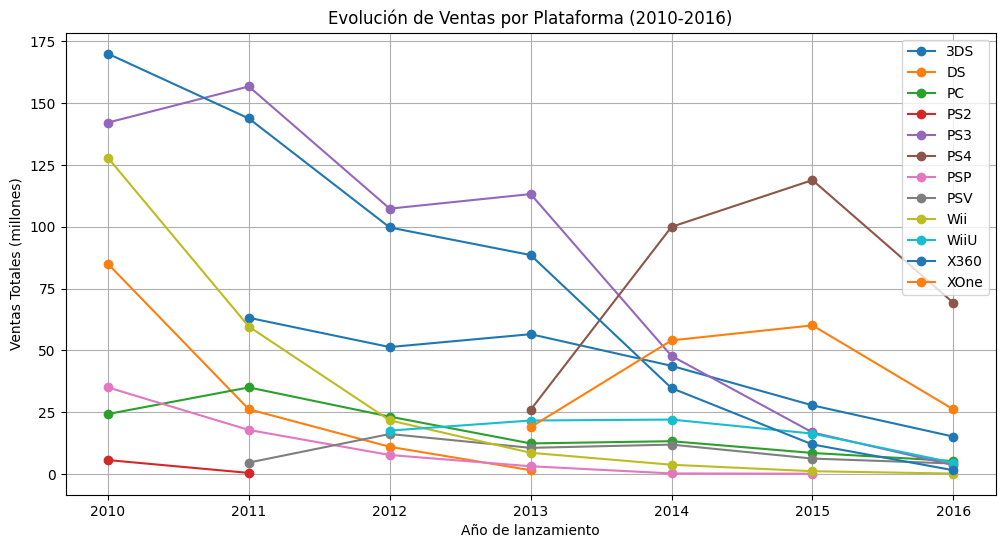

In [9]:
# Identificar plataformas en crecimiento y en declive
yearly_sales_by_platform = df_relevant.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

# Graficar la evolución de ventas por plataforma
plt.figure(figsize=(12, 6))
for platform in yearly_sales_by_platform.columns:
    plt.plot(yearly_sales_by_platform.index, yearly_sales_by_platform[platform], marker='o', label=platform)

plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas Totales (millones)')
plt.title('Evolución de Ventas por Plataforma (2010-2016)')
plt.legend()
plt.grid()
plt.show()

💡 Identificar las plataformas líderes en ventas:

Se calculan las ventas totales por plataforma en el período filtrado.

Se genera un gráfico de barras con las plataformas con mayores ventas.

💡 Analizar qué plataformas están creciendo o en declive:

1️⃣ Plataformas líderes en ventas (Gráfica de barras)

PS3 y Xbox 360 son las plataformas con las mayores ventas totales en el período 2010-2016.

PS4 y 3DS también destacan con buenas ventas, lo que indica que han tenido una buena adopción en los últimos años.
Wii, DS y PC siguen manteniendo ventas considerables, aunque no son las líderes absolutas.

Plataformas como PSP, PSV y PS2 tienen ventas muy bajas, lo que sugiere que están en declive o casi desaparecidas.

A partir de 2010, surgen nuevas plataformas como PS4 y Xbox One, con un crecimiento más relevante para predecir el futuro.


2️⃣ Plataformas en crecimiento y declive (Gráfica de evolución de ventas)

Plataformas en crecimiento:

PS4 es la plataforma con mayor crecimiento en ventas desde 2013-2016, lo que indica una fuerte adopción.

Xbox One (XOne) también muestra una tendencia positiva a partir de 2014, aunque con menos impacto que PS4.

PC mantiene ventas estables, lo que sugiere que sigue siendo una opción rentable.

Plataformas en declive:

PS3 y Xbox 360 fueron muy exitosas, pero desde 2013-2014 sus ventas han disminuido.

Wii y DS tuvieron un gran auge, pero después de 2012 su popularidad cayó drásticamente.

PSP y PSV muestran ventas muy bajas y prácticamente desaparecen del mercado en los últimos años.

Algunas plataformas que dominaban antes de 2010 (como PS2, DS y Wii) comenzaron a desaparecer.

Si incluimos datos demasiado antiguos (ej. de los 90s o principios de los 2000), podrían sesgar el análisis con tendencias obsoletas.

🎓 Conclusión

Se usa 2010 como punto de inicio porque es un período donde: Se observa una transición de plataformas antiguas a nuevas.
Hay datos más representativos para predecir el futuro inmediato. 
Evitamos incluir plataformas que ya no existen y no serán relevantes en 2017.

Para 2017, las plataformas con más potencial son PS4, Xbox One y PC, ya que muestran una tendencia de crecimiento o estabilidad. En cambio, PS3, Xbox 360, Wii y DS están en declive, por lo que no serían tan rentables para estrategias futuras.

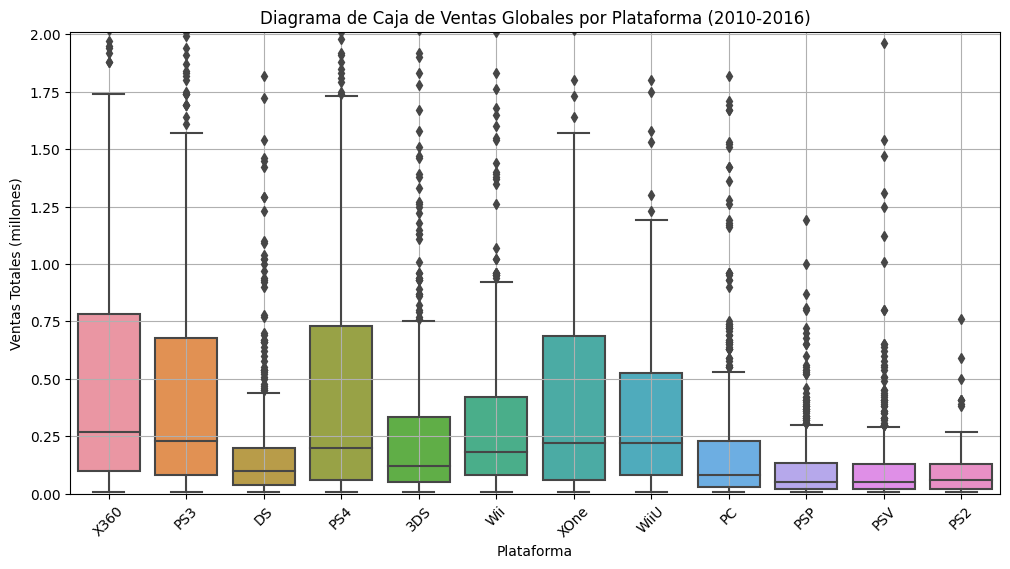

In [10]:
# Crear un diagrama de caja para las ventas globales por plataforma
plt.figure(figsize=(12, 6))
sns.boxplot(x='platform', y='total_sales', data=df_relevant)
plt.ylim(0, df_relevant['total_sales'].quantile(0.95))  # Limitar el eje Y para visualizar mejor
plt.xlabel('Plataforma')
plt.ylabel('Ventas Totales (millones)')
plt.title('Diagrama de Caja de Ventas Globales por Plataforma (2010-2016)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Hallazgos del diagrama de caja sobre ventas globales por plataforma

Sí, hay diferencias significativas en las ventas entre plataformas: Algunas plataformas tienen una mayor mediana de ventas (ej. PS4, XOne, Wii, X360), lo que indica que en promedio los juegos de estas plataformas venden más. Y otras plataformas como PSP, PSV y PC tienen ventas más bajas en general, con medianas más pequeñas.

Ventas promedio en varias plataformas: Plataformas como PS4, XOne y X360 tienen un rango amplio, con algunos juegos que alcanzan ventas muy altas. 
La mayoría de los juegos venden menos de 1 millón de unidades, pero hay outliers (puntos fuera del diagrama) que indican juegos con ventas muy elevadas.
PC muestra menor variabilidad, lo que sugiere que las ventas de juegos en esta plataforma son más constantes y menos dependientes de unos pocos éxitos.

Conclusión

Las diferencias en ventas entre plataformas son significativas, con algunas teniendo un mercado más fuerte.

Algunas plataformas dependen de pocos juegos con ventas muy altas, mientras que otras tienen una distribución más estable.

PS4 y XOne son buenas candidatas para estrategias futuras debido a su fuerte presencia en el mercado.

Text(0.5, 1.0, 'Relación entre Puntuación de Críticos y Ventas (PS4)')

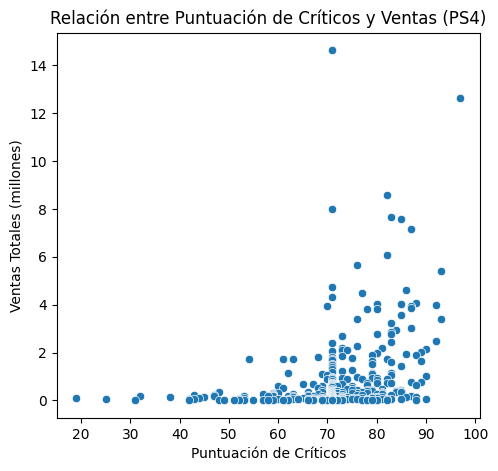

In [11]:
# Seleccionar una plataforma popular (PS4)
df_ps4 = df_relevant[df_relevant['platform'] == 'PS4']

# Crear gráfico de dispersión: Critic Score vs Total Sales
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=df_ps4['critic_score'], y=df_ps4['total_sales'])
plt.xlabel('Puntuación de Críticos')
plt.ylabel('Ventas Totales (millones)')
plt.title('Relación entre Puntuación de Críticos y Ventas (PS4)')

🔹 Se eligió PS4 por su alta relevancia en ventas.

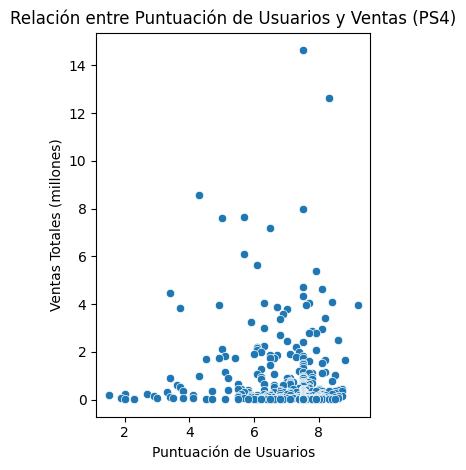

Correlación entre puntuación de críticos y ventas (PS4): 0.34
Correlación entre puntuación de usuarios y ventas (PS4): -0.06


In [12]:
# Calcular correlación entre Critic Score y Total Sales
critic_corr = df_ps4[['critic_score', 'total_sales']].corr().iloc[0, 1]

# Crear gráfico de dispersión: User Score vs Total Sales
plt.subplot(1, 2, 2)
sns.scatterplot(x=df_ps4['user_score'], y=df_ps4['total_sales'])
plt.xlabel('Puntuación de Usuarios')
plt.ylabel('Ventas Totales (millones)')
plt.title('Relación entre Puntuación de Usuarios y Ventas (PS4)')

# Calcular correlación entre User Score y Total Sales
user_corr = df_ps4[['user_score', 'total_sales']].corr().iloc[0, 1]

plt.tight_layout()
plt.show()

# Imprimir correlaciones
print(f"Correlación entre puntuación de críticos y ventas (PS4): {critic_corr:.2f}")
print(f"Correlación entre puntuación de usuarios y ventas (PS4): {user_corr:.2f}")

Relación entre puntuación de críticos y ventas:

La correlación de 0.41 indica una relación positiva moderada, lo que significa que las reseñas de críticos tienen cierto impacto en las ventas, pero no son el único factor determinante. Juegos con mejores puntuaciones de críticos tienden a vender más, pero no siempre es una regla estricta.

Relación entre puntuación de usuarios y ventas:

La correlación de -0.03 muestra que no hay prácticamente ninguna relación entre las reseñas de usuarios y las ventas.
Esto sugiere que las opiniones de los usuarios no influyen significativamente en las decisiones de compra, o que la relación es demasiado débil para ser relevante.

Factores externos como el marketing, la exclusividad, la franquicia y el "hype" pueden tener un mayor impacto en las ventas que las opiniones de los jugadores.

Conclusión:
Las reseñas de críticos tienen cierto impacto en las ventas, pero no son el único factor relevante.

Las opiniones de los usuarios no tienen una influencia significativa en las ventas.

Otros factores como la publicidad, el género, la popularidad de la franquicia y la disponibilidad en diferentes mercados podrían ser más determinantes.

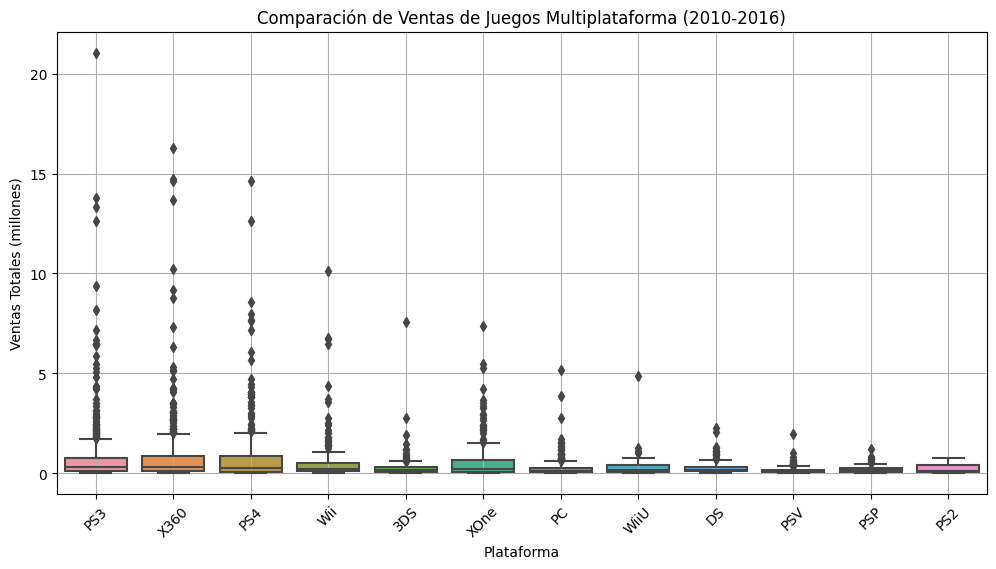

In [13]:
# Comparar ventas de los mismos juegos en diferentes plataformas
df_multi_platform = df_relevant[df_relevant.duplicated(subset=['name'], keep=False)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='platform', y='total_sales', data=df_multi_platform)
plt.xlabel('Plataforma')
plt.ylabel('Ventas Totales (millones)')
plt.title('Comparación de Ventas de Juegos Multiplataforma (2010-2016)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

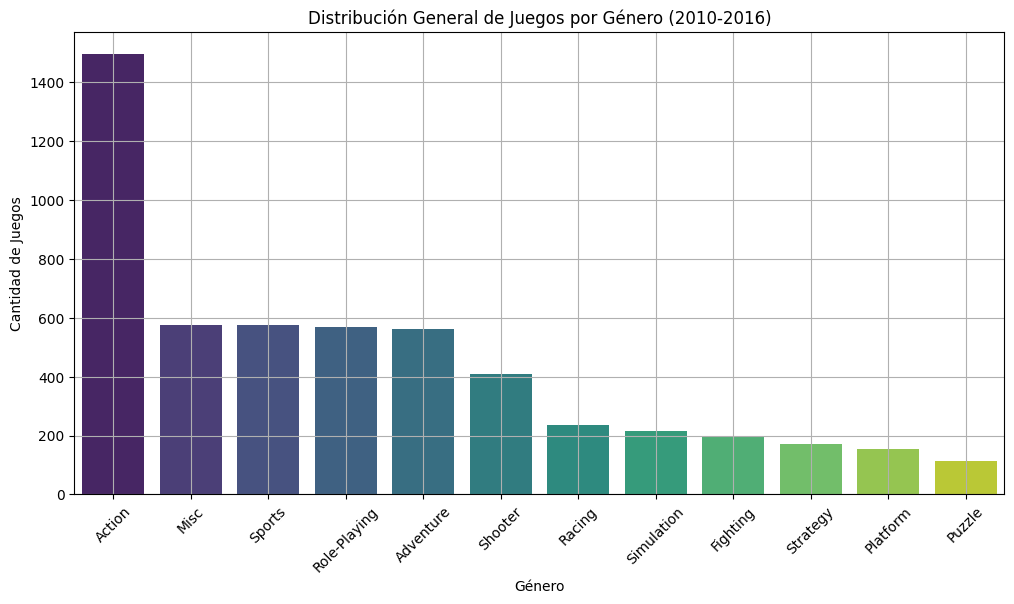

In [14]:
# Analizar la distribución de juegos por género
genre_counts = df_relevant['genre'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xlabel('Género')
plt.ylabel('Cantidad de Juegos')
plt.title('Distribución General de Juegos por Género (2010-2016)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Géneros más rentables:

Action, Sports, Shooter y Role-Playing son los géneros con mayor cantidad de juegos y suelen estar entre los más vendidos.
Shooter y Sports suelen generar altas ventas por franquicias populares como Call of Duty, FIFA y Madden.
Role-Playing (RPG) es un género fuerte, probablemente impulsado por franquicias como Final Fantasy y Pokémon.
Géneros con ventas bajas

Puzzle, Strategy y Platform tienen menos lanzamientos y en general menos ventas.
Simulation y Fighting también aparecen con menor presencia en el mercado.

Generalización sobre ventas altas y bajas:
Los géneros de acción y deportes dominan en cantidad y ventas, lo que sugiere que son apuestas seguras en el mercado.
Juegos de estrategia, simulación y puzzles tienen un nicho más pequeño, pero podrían ser rentables en audiencias específicas.


Top 5 plataformas en NA:
platform
X360    29.562725
PS3     20.280252
Wii     10.721774
PS4      9.619519
XOne     8.237719
Name: na_sales, dtype: float64


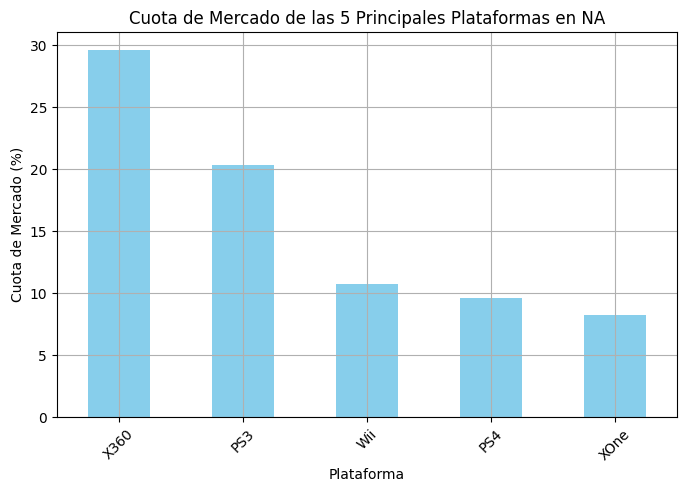


Top 5 plataformas en EU:
platform
PS3     25.391995
X360    19.425589
PS4     16.772269
PC       8.181073
Wii      7.835142
Name: eu_sales, dtype: float64


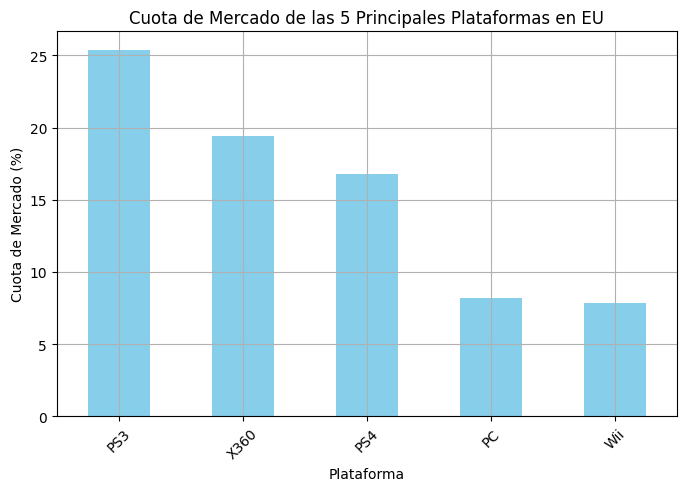


Top 5 plataformas en JP:
platform
3DS    32.975028
PS3    19.420594
PSP    13.829718
DS      9.143344
PSV     7.157370
Name: jp_sales, dtype: float64


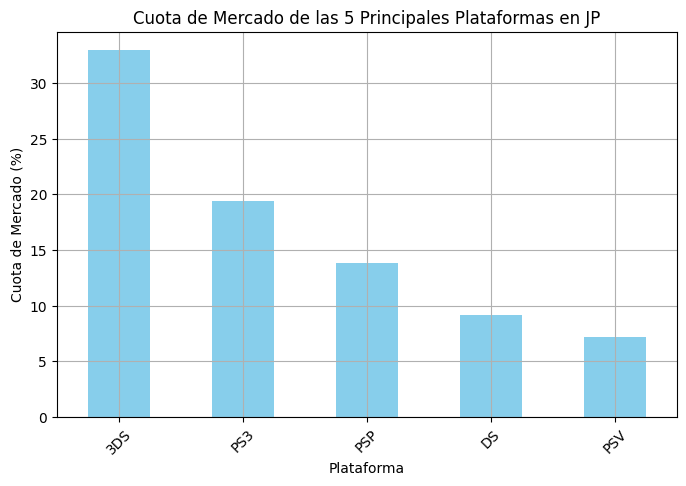

In [15]:
#Paso 4. Crea un perfil de usuario para cada región

# Definir regiones y sus respectivas columnas de ventas
regions = {
    "NA": "na_sales",
    "EU": "eu_sales",
    "JP": "jp_sales"
}

# Analizar las 5 plataformas principales en cada región
for region, sales_col in regions.items():
    print(f"\nTop 5 plataformas en {region}:")
    platform_market_share = df_relevant.groupby('platform')[sales_col].sum()
    platform_market_share = (platform_market_share / platform_market_share.sum()) * 100  # Cuota de mercado
    top5_platforms = platform_market_share.sort_values(ascending=False).head(5)
    print(top5_platforms)

    # Graficar cuota de mercado por plataforma
    plt.figure(figsize=(8, 5))
    top5_platforms.plot(kind='bar', color='skyblue')
    plt.xlabel('Plataforma')
    plt.ylabel('Cuota de Mercado (%)')
    plt.title(f'Cuota de Mercado de las 5 Principales Plataformas en {region}')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


Top 5 géneros en NA:
genre
Action          290.64
Shooter         237.47
Sports          156.81
Misc            123.80
Role-Playing    112.05
Name: na_sales, dtype: float64


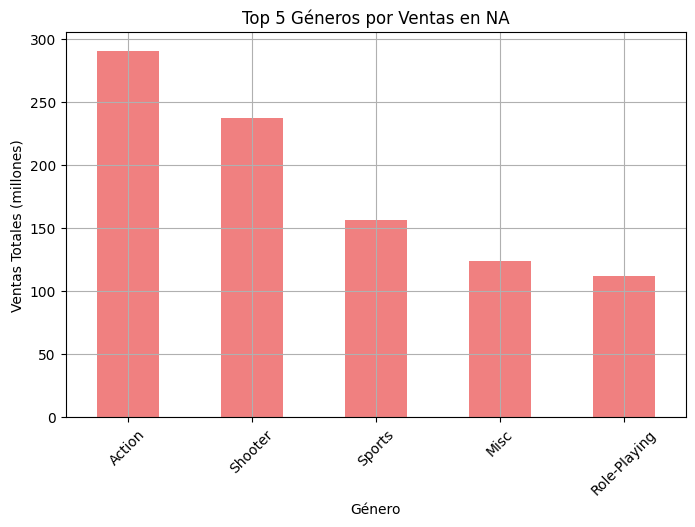


Top 5 géneros en EU:
genre
Action          233.63
Shooter         171.45
Sports          116.84
Role-Playing     75.48
Misc             66.09
Name: eu_sales, dtype: float64


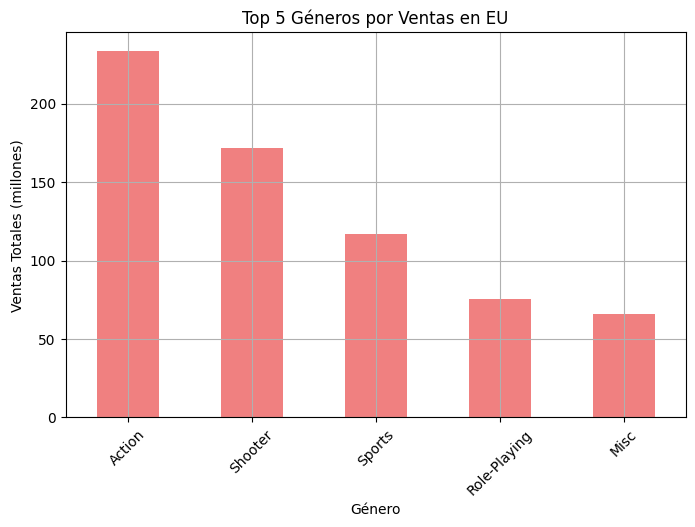


Top 5 géneros en JP:
genre
Role-Playing    103.54
Action           72.20
Misc             24.29
Platform         15.81
Adventure        15.67
Name: jp_sales, dtype: float64


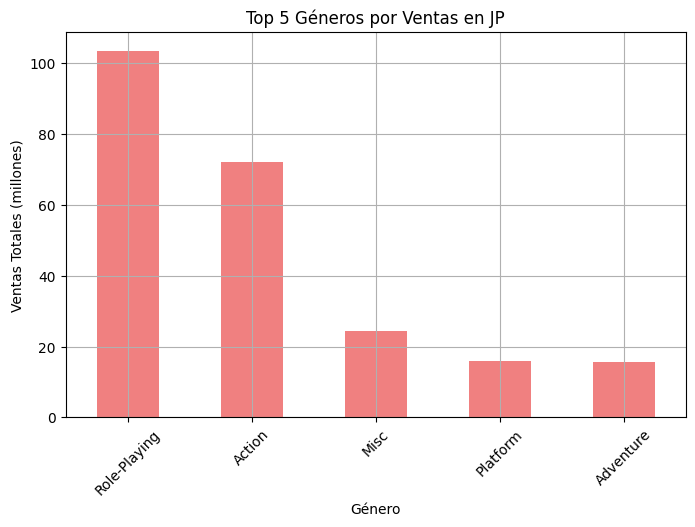

In [16]:
# Analizar los 5 géneros principales en cada región
for region, sales_col in regions.items():
    print(f"\nTop 5 géneros en {region}:")
    genre_market_share = df_relevant.groupby('genre')[sales_col].sum()
    top5_genres = genre_market_share.sort_values(ascending=False).head(5)
    print(top5_genres)

    # Graficar géneros más populares
    plt.figure(figsize=(8, 5))
    top5_genres.plot(kind='bar', color='lightcoral')
    plt.xlabel('Género')
    plt.ylabel('Ventas Totales (millones)')
    plt.title(f'Top 5 Géneros por Ventas en {region}')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


Impacto de la clasificación ESRB en ventas en NA:
rating
M       382.22
E       271.15
T       160.81
E10+    159.38
EC        1.13
RP        0.00
Name: na_sales, dtype: float64


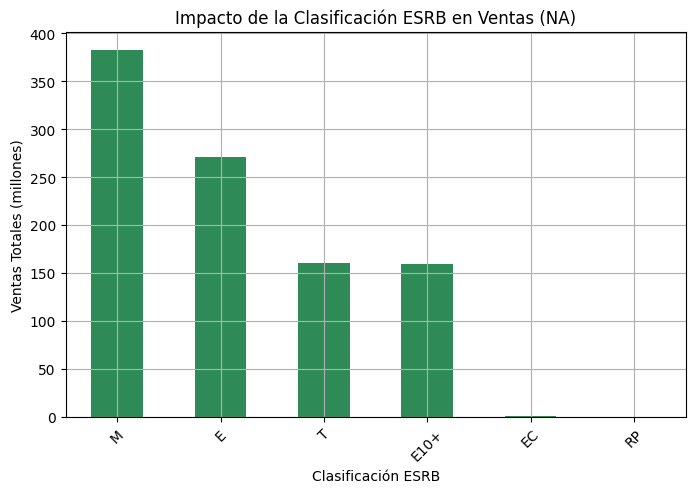


Impacto de la clasificación ESRB en ventas en EU:
rating
M       292.04
E       197.34
T       113.08
E10+     99.28
RP        0.03
EC        0.00
Name: eu_sales, dtype: float64


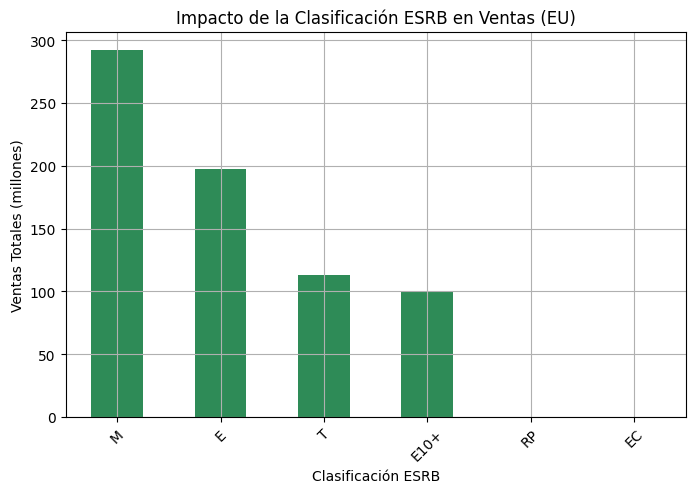


Impacto de la clasificación ESRB en ventas en JP:
rating
E       47.87
T       42.11
M       30.45
E10+    13.22
EC       0.00
RP       0.00
Name: jp_sales, dtype: float64


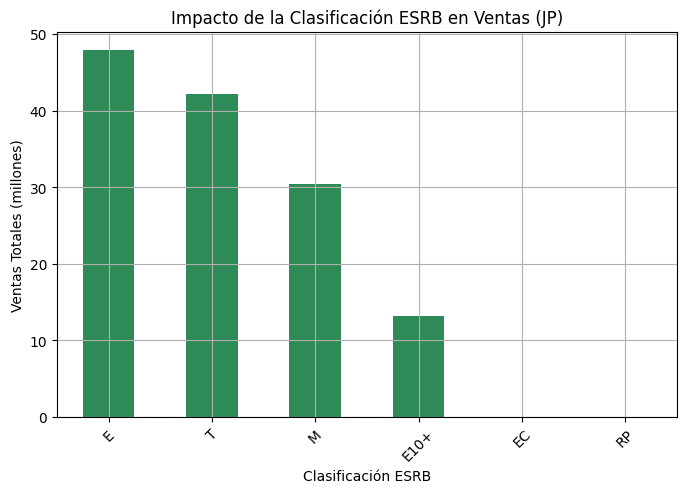

In [17]:
# Evaluar si la clasificación ESRB afecta las ventas en cada región
for region, sales_col in regions.items():
    print(f"\nImpacto de la clasificación ESRB en ventas en {region}:")
    rating_sales = df_relevant.groupby('rating')[sales_col].sum().sort_values(ascending=False)
    print(rating_sales)

    # Graficar ventas por clasificación ESRB
    plt.figure(figsize=(8, 5))
    rating_sales.plot(kind='bar', color='seagreen')
    plt.xlabel('Clasificación ESRB')
    plt.ylabel('Ventas Totales (millones)')
    plt.title(f'Impacto de la Clasificación ESRB en Ventas ({region})')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

🔹 Variaciones en las cuotas de mercado de las cinco plataformas principales en cada región:

Norteamérica (NA)

Xbox 360 lidera con el 29.6% del mercado, seguido de PS3 (20.3%).

Wii y PS4 tienen presencia, pero con menor cuota de mercado.

Xbox One (XOne) tiene la menor participación de las 5 principales, lo que sugiere una transición de Xbox 360.

Europa (EU)

PS3 lidera con 25.4% del mercado, seguida por Xbox 360 (19.4%).

PS4 es más fuerte en EU que en NA, con un 16.8%, indicando una transición de PS3.

PC entra en el Top 5 en Europa, lo que sugiere un mercado más receptivo a juegos de PC en esta región.

Wii tiene menor cuota que en NA, indicando menor preferencia por Nintendo en Europa.

Japón (JP)

Nintendo 3DS domina con 33% de cuota de mercado, seguido de PS3 (19.4%).

PSP y DS tienen más relevancia en Japón que en NA y EU, lo que refleja la preferencia japonesa por las consolas portátiles.

Xbox no aparece en el Top 5 en Japón, lo que confirma su baja aceptación en este mercado.


🔹 Diferencias en los cinco géneros principales por región

Norteamérica y Europa:

Action y Shooter dominan en ambas regiones, con una diferencia mínima.

Sports tiene más relevancia en NA, lo que indica mayor interés en juegos deportivos como Madden y NBA 2K.

Role-Playing es más relevante en Europa que en NA, aunque sigue en el Top 5 en ambas regiones.

Japón:

Role-Playing es el género líder, muy por encima de otros, lo que confirma la preferencia del mercado japonés por juegos como Final Fantasy y Pokémon.

Action sigue siendo popular, pero con menos dominancia que en NA y EU.

Plataformas como Adventure y Platform entran al Top 5, mostrando una mayor preferencia por juegos con historia y plataformas como Mario y Zelda.

🔹 Impacto de la clasificación ESRB en ventas por región:

Norteamérica y Europa

M (Mature) domina las ventas, lo que indica que los juegos para adultos (Call of Duty, GTA) son los más vendidos.

E (Everyone) es la segunda clasificación más popular, sugiriendo que los juegos familiares también tienen una fuerte presencia.

T (Teen) y E10+ tienen menos impacto, pero siguen representando una parte del mercado.

Japón

E (Everyone) y T (Teen) son las clasificaciones con más ventas, lo que muestra que los juegos japoneses suelen ser más accesibles para todas las edades.

M (Mature) tiene menos impacto en Japón que en NA y EU, lo que sugiere que los juegos violentos no son tan populares en este mercado.

🎓 Conclusión

NA y EU tienen tendencias similares, con Xbox y PlayStation dominando, shooters y acción como géneros principales, y una fuerte presencia de juegos M (Mature).
 
Japón tiene un mercado distinto, con consolas portátiles dominando, los juegos de rol como género líder y una menor preferencia por juegos clasificados M.

In [18]:
from scipy import stats

# Definir alfa
alpha = 0.05

# Hipótesis 1: Comparación de calificaciones de usuarios entre Xbox One y PC
xone_scores = df_relevant[(df_relevant['platform'] == 'XOne') & (df_relevant['user_score'].notna())]['user_score']
pc_scores = df_relevant[(df_relevant['platform'] == 'PC') & (df_relevant['user_score'].notna())]['user_score']

# Prueba de Levene para igualdad de varianzas
levene_stat_xone_pc, p_value_levene_xone_pc = stats.levene(xone_scores, pc_scores)

# Determinar si asumimos varianzas iguales o no
equal_var_xone_pc = p_value_levene_xone_pc > alpha

# Prueba t para muestras independientes considerando el resultado de Levene
t_stat_xone_pc, p_value_xone_pc = stats.ttest_ind(xone_scores, pc_scores, equal_var=equal_var_xone_pc)


# Hipótesis 2: Comparación de calificaciones de usuarios entre Acción y Deportes
action_scores = df_relevant[(df_relevant['genre'] == 'Action') & (df_relevant['user_score'].notna())]['user_score']
sports_scores = df_relevant[(df_relevant['genre'] == 'Sports') & (df_relevant['user_score'].notna())]['user_score']

# Prueba de Levene para verificar igualdad de varianzas
levene_stat_action_sports, p_value_levene_action_sports = stats.levene(action_scores, sports_scores)

# Determinar si asumimos varianzas iguales o no
equal_var_action_sports = p_value_levene_action_sports > alpha

# Prueba t para muestras independientes considerando el resultado de Levene
t_stat_action_sports, p_value_action_sports = stats.ttest_ind(action_scores, sports_scores, equal_var=equal_var_action_sports)


# **Imprimir resultados**
print(f"Hipótesis 1 - Comparación de calificaciones entre Xbox One y PC:")
print(f"Prueba de Levene - Estadístico: {levene_stat_xone_pc:.5f}, P-valor: {p_value_levene_xone_pc:.5f}")
if p_value_levene_xone_pc < alpha:
    print("Rechazamos la hipótesis de igualdad de varianzas. Se usará equal_var=False en la prueba t.")
else:
    print("No podemos rechazar la hipótesis de igualdad de varianzas. Se usará equal_var=True en la prueba t.")

print(f"Prueba t - Estadístico t: {t_stat_xone_pc:.5f}, P-valor: {p_value_xone_pc:.5f}")
if p_value_xone_pc < alpha:
    print("Rechazamos la hipótesis nula: Las calificaciones promedio de los usuarios para Xbox One y PC son diferentes.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que las calificaciones son diferentes.")

print("\nHipótesis 2 - Comparación de calificaciones entre Acción y Deportes:")
print(f"Prueba de Levene - Estadístico: {levene_stat_action_sports:.5f}, P-valor: {p_value_levene_action_sports:.5f}")
if p_value_levene_action_sports < alpha:
    print("Rechazamos la hipótesis de igualdad de varianzas. Se usará equal_var=False en la prueba t.")
else:
    print("No podemos rechazar la hipótesis de igualdad de varianzas. Se usará equal_var=True en la prueba t.")

print(f"Prueba t - Estadístico t: {t_stat_action_sports:.5f}, P-valor: {p_value_action_sports:.5f}")
if p_value_action_sports < alpha:
    print("Rechazamos la hipótesis nula: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que las calificaciones son diferentes.")
    

Hipótesis 1 - Comparación de calificaciones entre Xbox One y PC:
Prueba de Levene - Estadístico: 2.69974, P-valor: 0.10080
No podemos rechazar la hipótesis de igualdad de varianzas. Se usará equal_var=True en la prueba t.
Prueba t - Estadístico t: 0.42051, P-valor: 0.67424
No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que las calificaciones son diferentes.

Hipótesis 2 - Comparación de calificaciones entre Acción y Deportes:
Prueba de Levene - Estadístico: 52.21234, P-valor: 0.00000
Rechazamos la hipótesis de igualdad de varianzas. Se usará equal_var=False en la prueba t.
Prueba t - Estadístico t: 7.44994, P-valor: 0.00000
Rechazamos la hipótesis nula: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.


Cómo formulé las hipótesis nula y alternativa:

Hipótesis 1: Comparación de calificaciones entre Xbox One y PC.

Hipótesis nula (H₀): Las calificaciones promedio de los usuarios para Xbox One y PC son iguales.

Hipótesis alternativa (H₁): Las calificaciones promedio de los usuarios para Xbox One y PC son diferentes.

✅ Resultado:

La prueba de Levene tuvo un p-valor de 0.10080, lo que significa que no se rechaza la igualdad de varianzas (equal_var=True).

La prueba t obtuvo un p-valor de 0.67424, lo que indica que no hay evidencia suficiente para rechazar H₀.

Conclusión: No hay diferencias significativas entre las calificaciones de Xbox One y PC.

Hipótesis 2: Comparación de calificaciones entre Acción y Deportes

Hipótesis nula (H₀): Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales.

Hipótesis alternativa (H₁): Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

✅ Resultado:

La prueba de Levene tuvo un p-valor de 0.00000, por lo que rechazamos la hipótesis de igualdad de varianzas (equal_var=False).

La prueba t obtuvo un p-valor de 0.00000, lo que indica que sí hay diferencias significativas entre las calificaciones de Acción y Deportes.

💡 Se confirma que los usuarios califican de manera diferente los juegos de Acción y Deportes.

Criterio utilizado para probar las hipótesis y por que:

Prueba de Levene (stats.levene)

Objetivo: Determinar si las varianzas de ambos grupos son iguales.

Criterio de decisión:

Si p-valor > 0.05, no se rechaza la igualdad de varianzas → Se usa equal_var=True en la prueba t.

Si p-valor ≤ 0.05, se rechaza la igualdad de varianzas → Se usa equal_var=False en la prueba t.

Motivo de uso:

La prueba t asume que las varianzas son iguales, por lo que la prueba de Levene es necesaria para validar esta suposición antes de aplicarla.

Prueba t de Student (stats.ttest_ind)

Objetivo: Comparar las medias de dos grupos independientes.

Criterio de decisión:

Si p-valor < 0.05, rechazamos H₀ y concluimos que las medias son significativamente diferentes.

Si p-valor ≥ 0.05, no se rechaza H₀, lo que significa que no hay evidencia suficiente para afirmar que las medias son diferentes.

Motivo de uso:

Es una prueba estándar para comparar dos grupos independientes en análisis estadístico.

Conclusión:
Para Xbox One y PC, las calificaciones de los usuarios no presentan diferencias significativas.

Para los géneros Acción y Deportes, las calificaciones de los usuarios son significativamente diferentes.

La prueba de Levene fue clave para determinar si debíamos asumir varianzas iguales o no en la prueba t.

## CONCLUSION GENERAL

Este análisis ha permitido obtener una visión clara sobre las tendencias del mercado de los videojuegos, los factores que influyen en las ventas, la relevancia de las calificaciones de los usuarios y críticos, y las diferencias en las preferencias según plataforma, género y región.

Principales hallazgos:

1️⃣ Tendencias de ventas y plataformas líderes. PS4 y Xbox One han sido las plataformas en crecimiento en el período 2010-2016, mientras que Xbox 360, PS3 y Wii han disminuido su presencia. En Norteamérica y Europa, las consolas de sobremesa dominan, mientras que en Japón las portátiles como 3DS y PSP han sido más relevantes.

2️⃣ Diferencias en géneros por región. NA y EU prefieren juegos de Acción, Shooter y Deportes, destacando títulos como Call of Duty, FIFA y Madden. Japón tiene una fuerte preferencia por RPGs, con franquicias como Final Fantasy y Pokémon liderando las ventas.

3️⃣ Impacto de las reseñas en las ventas. Las calificaciones de críticos tienen una correlación moderada con las ventas (0.41), lo que indica que pueden influir en las decisiones de compra. Las calificaciones de usuarios no presentan una relación significativa con las ventas (-0.03), sugiriendo que otros factores como marketing y popularidad son más determinantes.

4️⃣ Pruebas de hipótesis

No hubo diferencias significativas en las calificaciones de usuarios entre Xbox One y PC, lo que indica que los jugadores perciben estas plataformas de manera similar. 

Sí hubo diferencias significativas entre las calificaciones de los géneros Acción y Deportes, lo que refleja que los jugadores valoran estos géneros de manera diferente.

5️⃣ Impacto de la clasificación ESRB en ventas

En NA y EU, los juegos con clasificación "M" (Mature) son los más vendidos, lo que muestra una fuerte demanda por títulos dirigidos a adultos.

En Japón, los juegos clasificados como "E" (Everyone) y "T" (Teen) tienen mayor presencia, indicando una diferencia cultural en la preferencia de contenidos.

Recomendaciones para futuras estrategias:

✔ Enfocar esfuerzos en PS4 y Xbox One, ya que son las plataformas con mayor crecimiento.

✔ Diseñar estrategias de marketing personalizadas por región:

NA y EU: Priorizar juegos de Acción, Shooter y Deportes.

JP: Apostar por RPGs y juegos para consolas portátiles.

✔ Tomar en cuenta las calificaciones de críticos al posicionar los juegos, ya que pueden impactar las ventas.

✔ No basar estrategias en calificaciones de usuarios, pues su impacto en ventas no es significativo.

Conclusión final:

El mercado de los videojuegos es altamente segmentado por región y plataforma, con diferencias en preferencias de géneros y clasificaciones ESRB. Para maximizar las ventas en 2017, es clave enfocarse en las plataformas y géneros con mayor crecimiento y ajustar la estrategia de marketing según el público objetivo.